In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#Get rid of SettingWithCopyWarnings
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  
import scipy.stats as stats

In [3]:
#We drop the unnecessary columns
roses = pd.read_csv('../../Data/processedData/Roses/labeledBigRose.csv', sep='\t')
roses = roses.drop(['observer_id', 'login', 'name', 'photo_page_url', 'photo_url_square', 'photo_uuid', 'license', 'quality_grade', 'taxon_id', 'rank', 'rank_level', 'active', 'ancestry', 'photo_id', 'extension', 'width', 'height', 'observation_uuid', 'position', 'Unnamed: 0', 'positional_accuracy'], axis=1)
roses = roses.dropna()

In [4]:
#We add two new columns onto roses that give the year of the observation and the number of days since the beginning of the year for that observation.
def get_year(date):
    try:
        return int(date[:4])
    except:
        return None

def days_since_start_of_year(month, day):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days = sum(days_in_month[:month - 1]) + day
    return days

def days_to_date(days):
    # Find the month and day corresponding to the average number of days
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    for i, days_this_month in enumerate(days_in_month):
        if days <= days_this_month:
            return i + 1, int(days)
        days -= days_this_month
    return 12, int(days)

def get_day(date):
    return days_since_start_of_year(int(date[5:7]), int(date[8:]))


roses["year"] = roses['observed_on'].apply(get_year)
roses["day"] = roses['observed_on'].apply(get_day)
roses.head()

,latitude,longitude,observed_on,taxon_name,fileName,inBloom,year,day
0,41.414216,-72.581309,2011-06-10,Rosa multiflora,D:\Roses\36944.jpg,True,2011,161
1,44.005329,-73.148262,2011-08-03,Rosa multiflora,D:\Roses\48170.jpg,False,2011,215
2,40.591600,-74.228482,2006-05-25,Rosa multiflora,D:\Roses\94456.jpg,True,2006,145
3,44.167488,-73.136091,2012-03-18,Rosa multiflora,D:\Roses\91270.jpg,False,2012,77
4,40.992833,-81.680167,2012-04-25,Rosa multiflora,D:\Roses\106185.jpg,False,2012,115


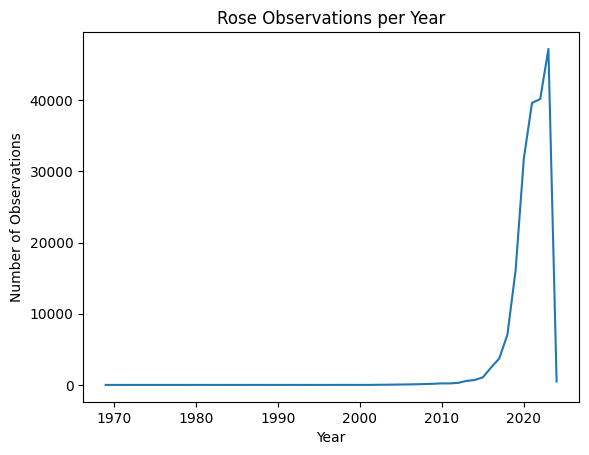

In [5]:
#First let's look at how our data is distributed over the years. We plot the total number of observations as a function of year. 
yearList = roses['year'].unique()
yearList.sort()
counts = []
for year in yearList:
    counts.append(roses[roses['year'] == year].shape[0])

plt.xlabel("Year")
plt.ylabel("Number of Observations")
plt.title("Rose Observations per Year")
plt.plot(yearList, counts)


We can see that observations before about 2015 are pretty few and far between. We also see that there are only a few observations in 2024. We limit our data to only those observations between 2015 and 2023. This will help eliminate outliers in the data set. This got rid of around 3000 total observations ~1.5% of the data. This will ensure that each year has at least 1000 observations.

In [46]:
roses = roses[roses['year'] >= 2015]
roses = roses[roses['year'] < 2024]
roses

,latitude,longitude,observed_on,taxon_name,fileName,inBloom,year,day
324,40.664836,-74.595677,2015-01-11,Rosa multiflora,D:\Roses\1481814.JPG,False,2015,11
325,40.640327,-74.448477,2015-01-07,Rosa multiflora,D:\Roses\1481860.JPG,False,2015,7
326,40.634164,-74.490802,2015-01-05,Rosa multiflora,D:\Roses\1481904.JPG,False,2015,5
327,40.632747,-74.461598,2015-01-06,Rosa multiflora,D:\Roses\1481928.JPG,False,2015,6
328,40.602435,-74.532516,2015-01-02,Rosa multiflora,D:\Roses\1481961.JPG,False,2015,2
...,...,...,...,...,...,...,...,...
193743,48.156175,-122.675383,2022-09-17,Rosa nutkana,D:\Roses\346582480.jpg,False,2022,260
193744,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792124.jpeg,False,2015,161
193745,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792131.jpeg,True,2015,161
193746,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792145.jpeg,False,2015,161


Now let's see how the average flowering day is trending and how it compares to the average observation day. To do this we'll make a new dataframe with rows indexed by years. 

In [71]:

observations = pd.DataFrame()
observations["year"] = roses['year'].unique()

def get_count(year):
    return roses[roses['year'] == year].shape[0]
    
observations['count'] = observations['year'].apply(get_count)

def get_flowering_count(year):
    observationsFromYear = roses[roses['year'] == year]
    observationsFromYearInBloom = observationsFromYear[observationsFromYear['inBloom'] == True]
    floweringCount = observationsFromYearInBloom.shape[0]
    return floweringCount

observations['floweringCount'] = observations['year'].apply(get_flowering_count)

def get_flowering_proportion(year):
    obCount = observations[observations['year'] == year]['count'].iloc[0]
    floweringCount = observations[observations['year'] == year]['floweringCount'].iloc[0]
    return floweringCount/obCount

observations['floweringProportion'] = observations['year'].apply(get_flowering_proportion)

def get_average_flowering_day(year):
    observationsFromYear = roses[roses["year"] == year]
    observationsFromYearInBloom = observationsFromYear[observationsFromYear['inBloom'] == True]
    return int(observationsFromYearInBloom['day'].mean())

def get_average_observation_day(year):
    return int(roses[roses["year"] == year]['day'].mean())

observations['averageFloweringDay'] = observations['year'].apply(get_average_flowering_day)
observations['averageObservationDay'] = observations['year'].apply(get_average_observation_day)


We plot the average flowering day vs the average observation day along with lines of best fit for each. 

In [74]:
modelFlower = LinearRegression()
modelFlower.fit(np.array(observations['year']).reshape(-1,1), np.array(observations['averageFloweringDay']).reshape(-1,1))

modelAll = LinearRegression()
modelAll.fit(np.array(observations['year']).reshape(-1,1), np.array(observations['averageObservationDay']).reshape(-1,1))

LinearRegression()

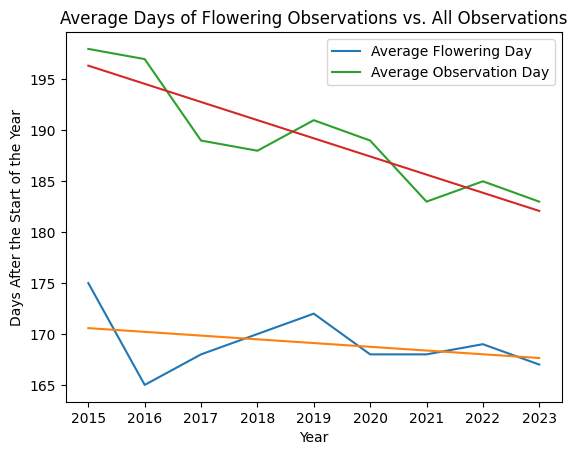

In [76]:

plt.xlabel("Year")
plt.ylabel("Days After the Start of the Year")
plt.title("Average Days of Flowering Observations vs. All Observations")

plt.plot(observations['year'], observations['averageFloweringDay'], label = 'Average Flowering Day')
plt.plot(observations['year'], modelFlower.predict(np.array(observations['year']).reshape(-1,1)))
plt.plot(observations['year'], observations['averageObservationDay'], label = 'Average Observation Day')
plt.plot(observations['year'], modelAll.predict(np.array(observations['year']).reshape(-1,1)))

plt.legend()


We can see that the trend is earlier and earlier in the year. We perform a two-sample t-test to determine whether the mean flowering day before 2020 is ealier than 2020 or later. This date was chosen in order to have a large number of data points both before and after it. 

In [113]:
beforeData = np.array(list(floweringDates[floweringDates["Year"] < 2020]['Days']))
afterData = np.array(list(floweringDates[floweringDates["Year"] >= 2020]['Days']))

# Print the variance of both data groups
print("Variances: ")
print(np.var(beforeData), np.var(afterData))
print("Means: ")
print(np.mean(beforeData), np.mean(afterData))

Variances: 
1824.5224733759042 1601.0642389124605
Means: 
171.505499276411 168.32639624640532


In [112]:
#We see the ratio < 4 so we can use a 2 sample t-test with equal variances. 
stats.ttest_ind(beforeData, afterData, equal_var=True)

TtestResult(statistic=8.39313697116405, pvalue=4.8095385208513527e-17, df=79888.0)

This is the two-sided p-value. Since the after mean is smaller then the one sided p-value would be 1/2 of this. We see that we can be relatively certain that the observed flowering date has gotten earlier in the year when we compare years before 2020 and those after 2019. 